In [23]:
import os
import glob
import torch
import numpy as np
import matplotlib.pyplot as plt

from opformer import TransformerOperator
import kernels
import dataset

/tmp/ipykernel_523956/3380382590.py:9: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ckpt = torch.load(checkpoint_path, map_location="cpu")


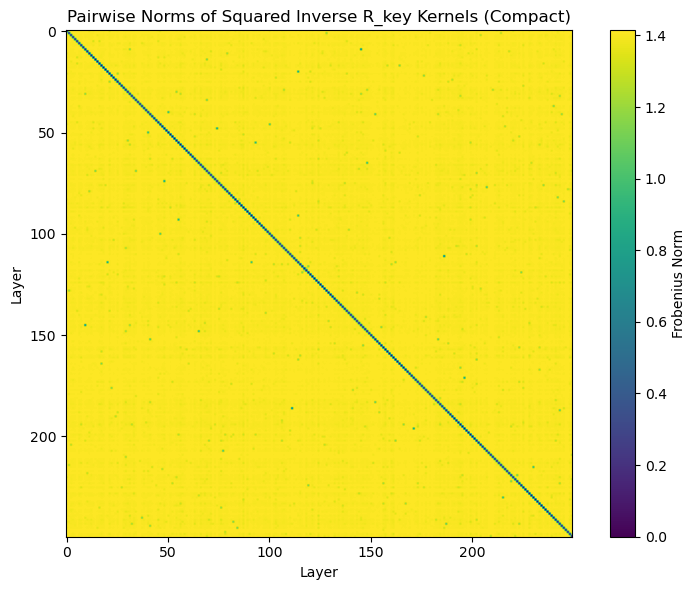

array([[0.        , 1.40922499, 1.40747082, ..., 1.41314375, 1.39896679,
        1.40628147],
       [1.40922499, 0.        , 1.41262865, ..., 1.4140228 , 1.4124583 ,
        1.41298175],
       [1.40747082, 1.41262865, 0.        , ..., 1.41251194, 1.40077662,
        1.40296018],
       ...,
       [1.41314375, 1.4140228 , 1.41251194, ..., 0.        , 1.41191375,
        1.41293442],
       [1.39896679, 1.4124583 , 1.40077662, ..., 1.41191375, 0.        ,
        1.39553177],
       [1.40628147, 1.41298175, 1.40296018, ..., 1.41293442, 1.39553177,
        0.        ]])

In [42]:
import os
import torch
import numpy as np
import matplotlib.pyplot as plt

H, W = 64, 64  # FFT size

def extract_R_kernels_compact(checkpoint_path, operator_type="key", num_layers=250):
    ckpt = torch.load(checkpoint_path, map_location="cpu")
    Rs = []
    for l in range(num_layers):
        prefix = f"layers.{l}.self_attn.{operator_type}_operator"
        w1 = ckpt[f"{prefix}.weights1"].squeeze(-1).squeeze().numpy()  # shape: (modes1, modes2)
        w2 = ckpt[f"{prefix}.weights2"].squeeze(-1).squeeze().numpy()  # shape: (modes1, modes2)
        # Just keep w1 and w2 individually to avoid unnecessary zero-padding
        Rs.append((w1, w2))
    return Rs

def compute_squared_inverse_compact(R_compact_list):
    Rs_inv_sq = []
    for w1, w2 in R_compact_list:
        inv1 = np.abs(1.0 / (w1 + 1e-8))**2
        inv2 = np.abs(1.0 / (w2 + 1e-8))**2

        # Flatten and normalize
        flat = np.concatenate([inv1.flatten(), inv2.flatten()])
        normed = flat / np.linalg.norm(flat)
        Rs_inv_sq.append(normed)
    return Rs_inv_sq

def plot_pairwise_norm_diffs(vectors, title="Pairwise Frobenius Norm Differences"):
    L = len(vectors)
    norm_diffs = np.zeros((L, L))
    for i in range(L):
        for j in range(L):
            norm_diffs[i, j] = np.linalg.norm(vectors[i] - vectors[j])

    plt.figure(figsize=(8, 6))
    plt.imshow(norm_diffs, cmap="viridis")
    plt.colorbar(label="Frobenius Norm")
    plt.title(title)
    plt.xlabel("Layer")
    plt.ylabel("Layer")
    plt.tight_layout()
    plt.show()
    return norm_diffs

def run_comparison_plots_compact(checkpoint_path, num_layers=250):
    for operator_type in ["key", "query"]:
        R_compact = extract_R_kernels_compact(checkpoint_path, operator_type, num_layers)
        R_inv_sq = compute_squared_inverse_compact(R_compact)
        title = f"Pairwise Norms of Squared Inverse R_{operator_type} Kernels (Compact)"
        diffs = plot_pairwise_norm_diffs(R_inv_sq, title)
        return diffs

# Example usage
checkpoint_files = sorted([f for f in os.listdir("checkpoints") if f.endswith(".pth")])
latest_ckpt = os.path.join("checkpoints", checkpoint_files[3])
run_comparison_plots_compact(latest_ckpt)  # Replace with latest_ckpt to check post-training

In [25]:
import os
import glob
import torch
import numpy as np
import matplotlib.pyplot as plt

from opformer import TransformerOperator
import kernels
import dataset

import dataset

H, W = 64, 64
kernel_maps = kernels.Kernels(H, W)

kx_name_true = 'linear'
kx_sigma = 1.0
kx_names = ['linear', 'laplacian', 'gradient_rbf', 'energy']
kx_true = kernels.get_kx_kernel(kx_name_true, sigma=kx_sigma)
ky_true = kernel_maps.get_kernel("gaussian")

num_samples = 25
f, Of = dataset.make_random_operator_dataset(
    kx_true, ky_true, num_samples=num_samples, num_bases=10, seed=0,
)
    
f_test = f[-1]
Of_test = Of[-1]

im_size = (64, 64)
device = "cuda"
Z_test = dataset.construct_Z(f_test, Of, f, im_size, device)

model = TransformerOperator(
    num_layers=250,
    im_size=im_size,
    ky_kernel=ky_true,
    kx_name=kx_name_true,
    kx_sigma=1.0,
    icl_lr=-0.01,
    icl_init=False
).to(device)

In [26]:
def load_latest_checkpoint(model, i, checkpoint_dir="checkpoints"):
    checkpoint_files = sorted(glob.glob(os.path.join(checkpoint_dir, "opformer_epoch_*.pth")))
    if not checkpoint_files:
        raise FileNotFoundError("No checkpoint files found in directory.")
    latest_ckpt = checkpoint_files[i]
    print(f"✅ Loading checkpoint: {latest_ckpt}")
    model.load_state_dict(torch.load(latest_ckpt))
    model.eval()
    return model

chkpt_errors = []
for i in range(28 // 2 + 1):
    model = load_latest_checkpoint(model, i)
    pred, preds = model(Z_test)
    errors = np.array([np.linalg.norm(test_pred + Of_test) for test_pred in preds])
    chkpt_errors.append(errors)

✅ Loading checkpoint: checkpoints/opformer_epoch_0.pth


/tmp/ipykernel_523956/3570107347.py:7: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(latest_ckpt))


✅ Loading checkpoint: checkpoints/opformer_epoch_10.pth
✅ Loading checkpoint: checkpoints/opformer_epoch_12.pth
✅ Loading checkpoint: checkpoints/opformer_epoch_14.pth
✅ Loading checkpoint: checkpoints/opformer_epoch_16.pth
✅ Loading checkpoint: checkpoints/opformer_epoch_18.pth
✅ Loading checkpoint: checkpoints/opformer_epoch_2.pth
✅ Loading checkpoint: checkpoints/opformer_epoch_20.pth
✅ Loading checkpoint: checkpoints/opformer_epoch_22.pth
✅ Loading checkpoint: checkpoints/opformer_epoch_24.pth
✅ Loading checkpoint: checkpoints/opformer_epoch_26.pth
✅ Loading checkpoint: checkpoints/opformer_epoch_28.pth
✅ Loading checkpoint: checkpoints/opformer_epoch_4.pth
✅ Loading checkpoint: checkpoints/opformer_epoch_6.pth
✅ Loading checkpoint: checkpoints/opformer_epoch_8.pth


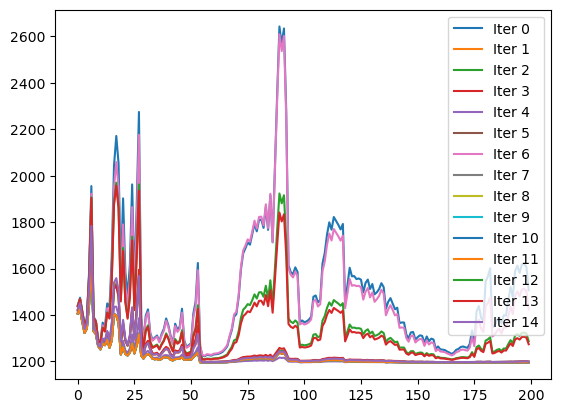

In [27]:
for i, errors in enumerate(chkpt_errors):
    plt.plot(errors[:-50], label=f"Iter {i}")
plt.legend()

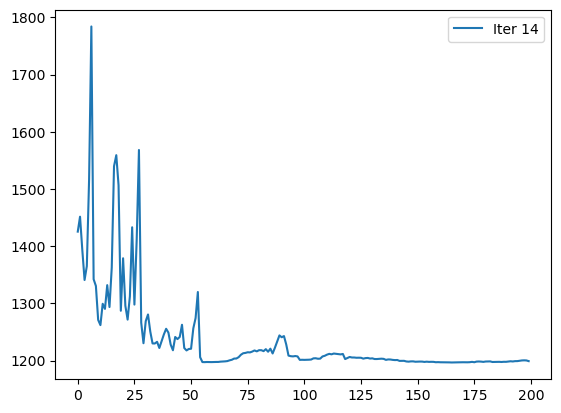

In [39]:
plt.plot(chkpt_errors[-1][:-50], label=f"Iter {i}")
plt.legend()

In [8]:
checkpoint_files

['opformer_epoch_0.pth', 'opformer_epoch_2.pth', 'opformer_epoch_4.pth']

In [4]:
ckpt = torch.load("init.pt", map_location="cpu")
ws = []
for l in range(3):
    prefix = f"layers.{l}.self_attn.key_operator"
    ws.append(ckpt[f"{prefix}.weights1"].squeeze(-1).squeeze().numpy())

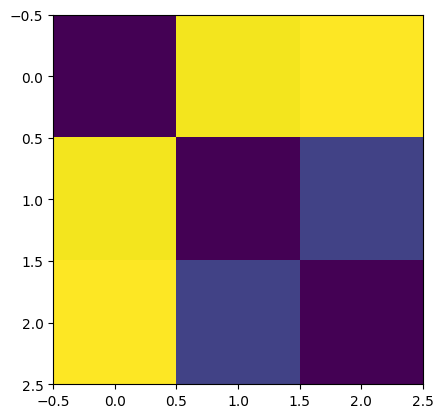

In [5]:
plt.imshow(Rs_inv_sq)

In [6]:
Rs = extract_R_kernels("init.pt", num_layers=3)

In [10]:
R_invs = []
for R in Rs:
    R_inv = np.abs(1.0 / (R + 1e-8))**2
    R_invs.append(R_inv / np.linalg.norm(R_inv, ord="fro"))  # normalize

In [19]:
ckpt = torch.load("init.pt", map_location="cpu")
layer_idx = 1
prefix = f"layers.{layer_idx}.self_attn.key_operator"
w1 = ckpt[f"{prefix}.weights1"].squeeze(-1).squeeze().numpy()  # shape: (H', W')
w2 = ckpt[f"{prefix}.weights2"].squeeze(-1).squeeze().numpy()

In [20]:
full_R = np.zeros((H, W), dtype=np.complex64)
modes1, modes2 = w1.shape
full_R[:modes1, :modes2] = w1
full_R[-modes1:, :modes2] = w2

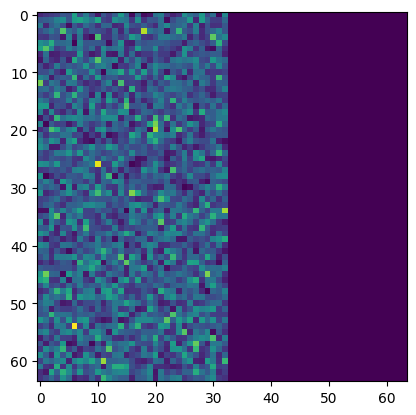

In [25]:
plt.imshow(np.abs(full_R))